In [53]:
import numpy as np

# Number of arms
num_arms = 10

# Initialize reward means for each arm
reward_means = np.zeros(num_arms)

print("Initial reward means:", reward_means)

Initial reward means: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [54]:
def update_reward_means(reward_means, step_std=0.01):
    """Updates the reward means with a random walk."""
    random_walks = np.random.normal(0, step_std, size=num_arms)
    reward_means += random_walks
    return reward_means

# Let's test the function:
reward_means = update_reward_means(reward_means)
print("Updated reward means after one random walk:", reward_means)


Updated reward means after one random walk: [ 0.00423415 -0.00674086  0.02014414 -0.00986585  0.01717499  0.00080771
 -0.00412963  0.00290521  0.01135448  0.00456976]


In [55]:
# Initialize estimated Q-values for each arm
Q_values = np.zeros(num_arms)

print("Initial Q-values:", Q_values)

Initial Q-values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
from abc import ABC, abstractmethod

class BanditAlgorithm(ABC):

    def __init__(self, num_arms=10):
        self.num_arms = num_arms
        self.reset()

    @abstractmethod
    def select_action(self):
        pass

    @abstractmethod
    def update_values(self, action, reward):
        pass

    def reset(self):
        pass  # To be extended by subclasses if needed

    def run(self, reward_means, num_steps=1000):
        rewards_received = []
        for _ in range(num_steps):
            action = self.select_action()
            reward = np.random.normal(reward_means[action], 0.1)
            self.update_values(action, reward)
            reward_means = update_reward_means(reward_means)
            rewards_received.append(reward)
        return rewards_received


In [57]:
class EpsilonGreedySampleAverage(BanditAlgorithm):

    def __init__(self, epsilon=0.1, alpha=None, num_arms=10):
        super().__init__(num_arms)
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_counts = np.zeros(num_arms)

    def select_action(self):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.num_arms)
        return np.argmax(self.Q_values)

    def update_values(self, action, reward):
        self.action_counts[action] += 1
        if self.alpha is None:  # Sample average update
            alpha = 1 / self.action_counts[action]
        else:
            alpha = self.alpha
        self.Q_values[action] += alpha * (reward - self.Q_values[action])

    def reset(self):
        self.Q_values = np.zeros(self.num_arms)
        self.action_counts = np.zeros(self.num_arms)


In [58]:
class OptimisticInitialValues(BanditAlgorithm):

    def __init__(self, initial_value=5.0, alpha=0.1, num_arms=10):
        self.initial_value = initial_value
        super().__init__(num_arms)
        self.alpha = alpha

    def select_action(self):
        return np.argmax(self.Q_values)

    def update_values(self, action, reward):
        self.Q_values[action] += self.alpha * (reward - self.Q_values[action])

    def reset(self):
        self.Q_values = np.full(self.num_arms, self.initial_value)


In [59]:
class GradientBandit(BanditAlgorithm):

    def __init__(self, alpha=0.1, num_arms=10):
        super().__init__(num_arms)
        self.alpha = alpha

    def select_action(self):
        prob = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        return np.random.choice(self.num_arms, p=prob)

    def update_values(self, action, reward):
        prob = np.exp(self.preferences) / np.sum(np.exp(self.preferences))
        baseline = np.dot(prob, self.Q_values)
        one_hot = np.zeros(self.num_arms)
        one_hot[action] = 1
        self.preferences += self.alpha * (reward - baseline) * (one_hot - prob)
        self.Q_values[action] += 1 / (self.action_counts[action] + 1) * (reward - self.Q_values[action])

    def reset(self):
        self.preferences = np.zeros(self.num_arms)
        self.Q_values = np.zeros(self.num_arms)
        self.action_counts = np.zeros(self.num_arms)

In [60]:
class UCB(BanditAlgorithm):

    def __init__(self, c=1.0, num_arms=10):
        super().__init__(num_arms)
        self.c = c

    def select_action(self):
        exploration = self.c * np.sqrt(np.log(sum(self.action_counts) + 1) / (self.action_counts + 1e-5))
        return np.argmax(self.Q_values + exploration)

    def update_values(self, action, reward):
        self.action_counts[action] += 1
        self.Q_values[action] += 1 / self.action_counts[action] * (reward - self.Q_values[action])

    def reset(self):
        self.Q_values = np.zeros(self.num_arms)
        self.action_counts = np.zeros(self.num_arms)


In [61]:
from tqdm import tqdm

def run_bandit_experiment(algorithm, num_runs=500, num_steps=5000):
    """
    Run the bandit experiment for the given algorithm over specified runs and steps.

    Parameters:
    - algorithm : Instance of BanditAlgorithm (or its child class).
    - num_runs : Number of independent runs.
    - num_steps : Number of steps in each run.

    Returns:
    - average_reward : Average reward over the last half of the steps for all runs.
    """

    all_rewards = []

    for run in tqdm(range(num_runs), desc=f"Running {algorithm.__class__.__name__}"):  # Progress bar for runs
        # Reset Q-values and other algorithm-specific states
        algorithm.reset()

        # Environment's true reward means
        reward_means = np.zeros(algorithm.num_arms)

        rewards_received = []

        for step in range(num_steps):
            # Algorithm selects action
            action = algorithm.select_action()

            # Environment gives reward
            reward = np.random.normal(reward_means[action], 0.5)
            rewards_received.append(reward)

            # Algorithm updates its values
            algorithm.update_values(action, reward)

            # Update environment's reward means (random walk)
            reward_means = update_reward_means(reward_means)

        half_avg_reward = np.mean(rewards_received[-(num_steps // 2):])
        all_rewards.append(half_avg_reward)

    average_reward = np.mean(all_rewards)

    return average_reward


In [67]:
# Create instances for each algorithm with different hyperparameters
algos = [
    EpsilonGreedySampleAverage(epsilon=0.1, alpha=2.0),
    EpsilonGreedySampleAverage(epsilon=0.1, alpha=1.0),
    EpsilonGreedySampleAverage(epsilon=0.1, alpha=0.1),
    EpsilonGreedySampleAverage(epsilon=0.1, alpha=0.01),
    EpsilonGreedySampleAverage(epsilon=0.1, alpha=0.001),
    OptimisticInitialValues(initial_value=5.0, alpha=2.0),
    OptimisticInitialValues(initial_value=5.0, alpha=1.0),
    OptimisticInitialValues(initial_value=5.0, alpha=0.1),
    OptimisticInitialValues(initial_value=5.0, alpha=0.01),
    OptimisticInitialValues(initial_value=5.0, alpha=0.001),
    GradientBandit(alpha=2.0),
    GradientBandit(alpha=1.0),
    GradientBandit(alpha=0.1),
    GradientBandit(alpha=0.01),
    GradientBandit(alpha=0.001),
    UCB(c=2.0),
    UCB(c=1.0),
    UCB(c=0.1),
    UCB(c=0.01),
    UCB(c=0.001)
]

results = {}
for algo in algos:
    avg_reward = run_bandit_experiment(algo)
    alpha_value = getattr(algo, 'alpha', getattr(algo, 'c', 'unknown'))
    results[algo.__class__.__name__ + str(alpha_value)] = avg_reward


print(results)


Running UCB: 100%|██████████| 500/500 [00:56<00:00,  8.90it/s]

{'EpsilonGreedySampleAverage2.0': 0.009823957514662869, 'EpsilonGreedySampleAverage1.0': 0.6857405256085848, 'EpsilonGreedySampleAverage0.1': 0.8186975483192086, 'EpsilonGreedySampleAverage0.01': 0.6713379770058115, 'EpsilonGreedySampleAverage0.001': 0.5212235397704924, 'OptimisticInitialValues2.0': 0.038073427478867355, 'OptimisticInitialValues1.0': 0.7146867019281885, 'OptimisticInitialValues0.1': 0.7678888833832398, 'OptimisticInitialValues0.01': 0.8620026273629312, 'OptimisticInitialValues0.001': 0.09169847583222969, 'GradientBandit2.0': 0.30068903208493314, 'GradientBandit1.0': 0.4308916522369748, 'GradientBandit0.1': 0.6342035622890876, 'GradientBandit0.01': 0.6215146898687433, 'GradientBandit0.001': 0.08721735558940176, 'UCB2.0': 0.8163720676962258, 'UCB1.0': 0.720436407959234, 'UCB0.1': 0.4317678963176133, 'UCB0.01': 0.38593254525553833, 'UCB0.001': 0.384715258263233}


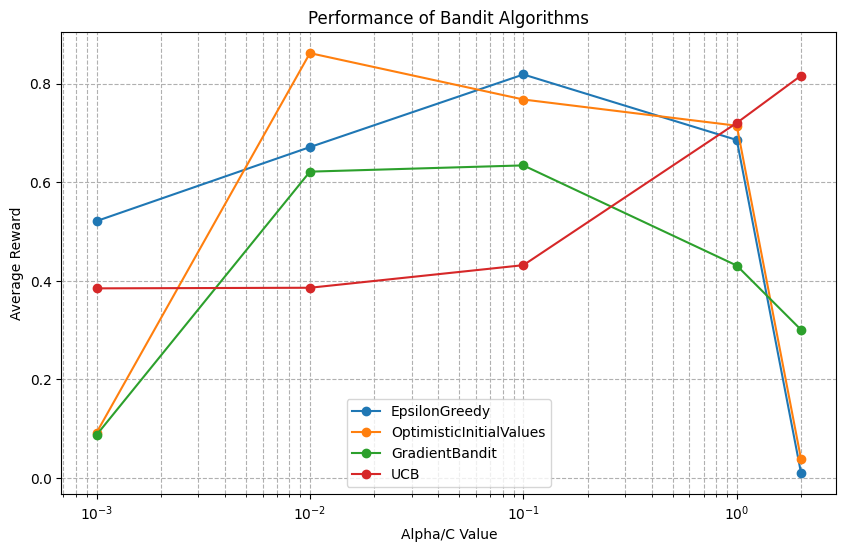

In [68]:
import matplotlib.pyplot as plt

import re

def extract_numeric_value(s):
    return float(re.search(r"[\d.]+", s).group())
import matplotlib.pyplot as plt

algorithms = ["EpsilonGreedy", "OptimisticInitialValues", "GradientBandit", "UCB"]

# Setting up the plot
plt.figure(figsize=(10, 6))

# Looping over algorithms and plotting
for algo in algorithms:
    specific_results = {key: results[key] for key in results if algo in key}
    param_values = [extract_numeric_value(key) for key in specific_results.keys()]
    rewards = list(specific_results.values())

    # Sort results by parameter value to ensure the plot is ordered
    sorted_pairs = sorted(zip(param_values, rewards))
    sorted_param_values, sorted_rewards = zip(*sorted_pairs)

    plt.plot(sorted_param_values, sorted_rewards, label=algo, marker='o')

# Labeling the plot
plt.xlabel('Alpha/C Value')
plt.ylabel('Average Reward')
plt.title('Performance of Bandit Algorithms')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
